# Analyze Consumer Plans Behavior

### Table of Contents
* [Analyze Consumer Plans Behavior](#scrollTo=6ONRPXUMitCd)
    * [Introduce to Machine Learning (Phone Plan)](#scrollTo=HFVBp3qwiTvA)
    * [1. Initialization and Data Preparation](#scrollTo=PiDM_Gd0iTvO)
        * [1.1. Display Sample Data and Study It](#scrollTo=4ENFHQpTiTvT)
        * [1.2. Improve Data Quality](#scrollTo=298uMRwWiTve)
    * [2. EDA and Data Visualization](#scrollTo=wmzRRWxPiTvj)
    * [3. Split the Data](#scrollTo=OARiaTeWiTvo)
    * [4. Models](#scrollTo=wk0E7kcxiTvx)
        * [4.1. Logistic Regression](#scrollTo=kcyF3SDriTvy)
        * [4.2. Decision Tree](#scrollTo=ozwoXLqviTv-)
        * [4.3. Random Forest](#scrollTo=nCThytaviTwK)
        * [4.4. KNN](#scrollTo=lGhO-2HSiTwR)
    * [5. Perform Sanity Check](#scrollTo=s5fNseAeZeWJ)
* [Conclusions](#scrollTo=1Pk9EbU3iTwV)



## Introduce to Machine Learning (Phone Plan)

Mobile operator Megaline is dissatisfied because many customers still need to use old packages. The company wants to develop a model that can analyze consumer behavior and recommend one of the two new Megaline packages: Smart or Ultra.

We have access to the behavioral data of customers who have switched to the latest package (from the Statistical Data Analysis course project). We must develop a model to choose the right package for this classification task. Considering that we have completed the data pre-processing step, we can go directly to the model-building stage.

We will develop a model that has the highest possible accuracy. In this project, the threshold for the accuracy level is 0.75. We will examine the model accuracy metrics using a test dataset.

**Goals:**
1. Separating the source data into training, validation, and test sets.
2. Check the quality of different models by changing their hyperparameters. Briefly explain the findings obtained from this study.
3. Checking the quality of the model using a test set.
4. Conduct a sanity check on the model.

## 1. Initialization and Data Preparation

In [1]:
# Load all libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# ml libraries
!pip install fast_ml
from sklearn.model_selection import train_test_split
from fast_ml.model_development import train_valid_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### 1.1. Display Sample Data and Study It

In [2]:
# Load the data
df = pd.read_csv('https://practicum-content.s3.us-west-1.amazonaws.com/datasets/users_behavior.csv')

In [3]:
# Display the sample of dataset
df

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
...,...,...,...,...,...
3209,122.0,910.98,20.0,35124.90,1
3210,25.0,190.36,0.0,3275.61,0
3211,97.0,634.44,70.0,13974.06,0
3212,64.0,462.32,90.0,31239.78,0


In [4]:
# display dataset information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


Our dataset consists of **4** columns and **3214** rows. There are 4 columns described as **float**, namely the `calls`, `minutes`, `messages`, and `mb_used` columns. The `minutes` and `mb_used` fields should have the appropriate data type as they contain the number of call minutes and data usage in *megabytes*, while the `calls` and `messages` fields should have an **int** data type as they contain the number of calls and the number of text messages. The `is_ultra` column already has the appropriate data type.

### 1.2. Improve Data Quality

In [5]:
# fix data type
for col in ['calls', 'messages']:
    df[col] = df[col].apply(np.int64)
    
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   int64  
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   int64  
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 125.7 KB


Kita telah memperbaiki type data kolom.

In [6]:
# displays descriptive statistics of the dataset
df.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


From the table above, we know that the average customer spends **63** on calls, **438** minutes of talk time, **38** on text messages, and **17** GB of data in that period. Meanwhile, the minimum usage by customers is using only some of the quota in every service we provide. The highest usage was **244** calls, **1632** minutes, **244** texts, and **49** gb data in that period.

In [7]:
# check for missing values
df.isna().sum()

calls       0
minutes     0
messages    0
mb_used     0
is_ultra    0
dtype: int64

No missing values were found.

## 3. EDA and Data Visualization

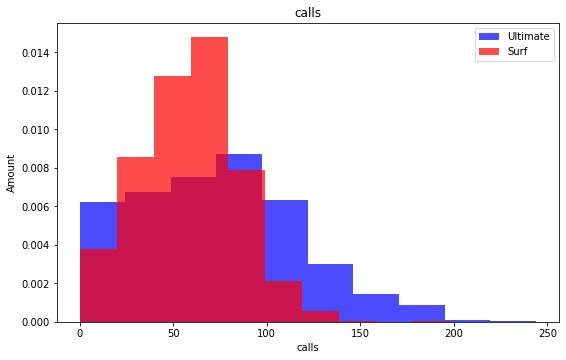

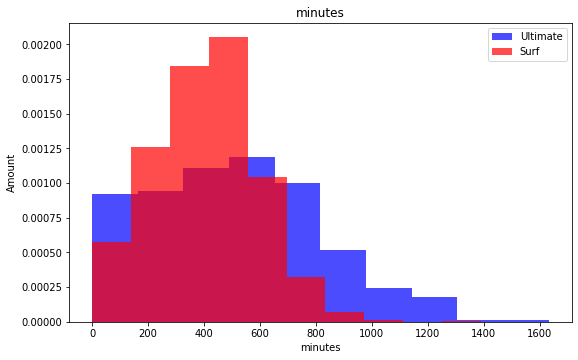

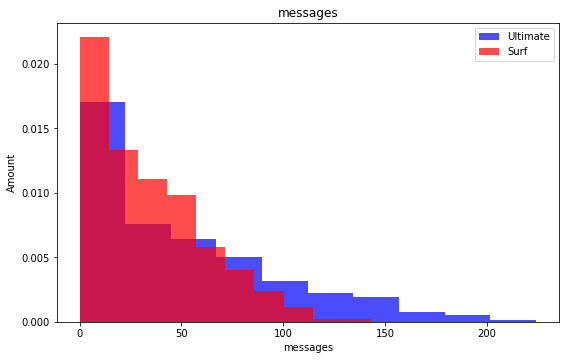

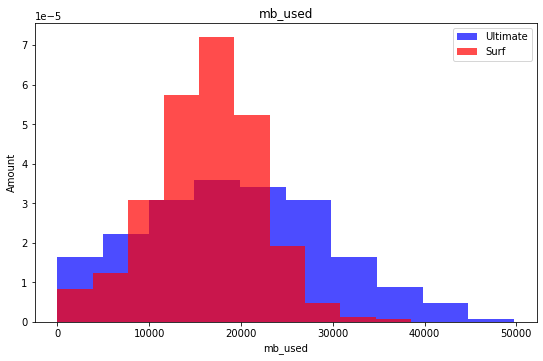

In [8]:
# Display data visualization
for label in df.columns[:-1]:
    plt.figure(figsize=(9, 5.5))
    plt.hist(df[df['is_ultra']==1][label], color='blue', label='Ultimate', alpha=0.7, density=True)
    plt.hist(df[df['is_ultra']==0][label], color='red', label='Surf', alpha=0.7, density=True)
    plt.title(label)
    plt.ylabel('Amount')
    plt.xlabel(label)
    plt.legend()
    plt.show()

**Findings:**
- From the graph of the number of calls made, the average user makes **30-80** calls in one month.
- The average user spends **250-500** minutes on calls in a month.
- On average, users of both packages do not use their text message quota at all. This might be because they have switched to *instant* messaging or *chatting* applications using internet data.
- Data users use on both plans is around the rate of **10,000-20,000 mb** in one month.

## 3. Split the Data

In [9]:
# Display the number of columns is_ultra
df.groupby('is_ultra').agg(count=('calls', 'count')).reset_index()

,is_ultra,count
0,0,2229
1,1,985


In [10]:
# calculate the ratio
df['is_ultra'].value_counts() / df.shape[0]

0    0.693528
1    0.306472
Name: is_ultra, dtype: float64

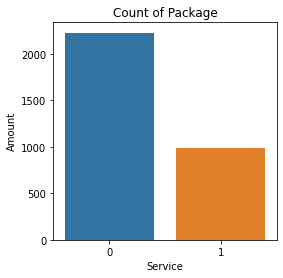

In [11]:
# Creating diagrams to count the plan distribution
plt.figure(figsize=(4,4))
sns.countplot(x='is_ultra', data=df, order=df['is_ultra'].value_counts().index)
plt.xlabel('Service')
plt.ylabel('Amount')
plt.title('Count of Package')
plt.show()

- We see an unbalanced number of package users in the dataset. It will undoubtedly have an impact on the model we will make.

- The ratio column `is_ultra` has a ratio of **70:30 %**. It may result in the model needing to learn the data properly.

In [12]:
# split the data in to training, validation, and test
X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(df, target = 'is_ultra', train_size=0.70,
                                                                            valid_size=0.15, test_size=0.15, random_state=12)

We will use the proportion of data as **70%** for *data training*, **15%** for *data validation*, and **15%** for *data test*. We set the value `random_state` to avoid different results if we re-run the code on *notebook*.

In [13]:
# check data dimension X_train
X_train.shape

(2249, 4)

In [14]:
# check data dimension X_valid
X_valid.shape

(482, 4)

In [15]:
# check data dimension X_test
X_test.shape

(483, 4)

In [16]:
# display sample training data
X_train.head()

,calls,minutes,messages,mb_used
643,136,965.78,0,31992.10
404,30,169.02,13,16626.53
1637,50,282.87,53,13260.03
551,0,0.00,24,18701.54
3177,114,731.76,10,25311.22


## 4. Models

### 4.1. Logistic Regression

In [17]:
# accuracy score lr model training set and validation set
print('Logistic Regression Model')
lr_result = defaultdict(list)

for solv in ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']:    
    lr_model = LogisticRegression(solver=solv)
    lr_model.fit(X_train, y_train)
    lr_model_train_pred = lr_model.predict(X_train)
    lr_model_valid_pred = lr_model.predict(X_valid)
    lr_result['solver'].append(solv)
    lr_result['train_accuracy'].append(accuracy_score(y_train, lr_model_train_pred))
    lr_result['valid_accuracy'].append(accuracy_score(y_valid, lr_model_valid_pred))
    
display(pd.DataFrame(lr_result))

Logistic Regression Model


,solver,train_accuracy,valid_accuracy
0,newton-cg,0.755002,0.742739
1,lbfgs,0.738550,0.728216
2,liblinear,0.745665,0.724066
3,sag,0.703868,0.682573
4,saga,0.703868,0.682573


The results of the **Logistic Regression Model** produce an *accuracy* level of **75%** for *training test* and **74%** for *validation test* by specifying **newton-cg** in the parameter ` solver`, meaning *validation set* is unable to reach the specified *accuracy* level of 75%. Next, we will apply this model to *test set*.

In [18]:
# create the best logisticregression model
lr_model = LogisticRegression(solver='newton-cg')
lr_model.fit(X_train, y_train)

LogisticRegression(solver='newton-cg')

In [19]:
# accuracy score lg model compare
print('Logistic Regression Model')
print('-------------------------')
y_train_lr_pred = lr_model.predict(X_train)
print('Training set accuracy =', accuracy_score(y_train, y_train_lr_pred))
y_valid_lr_pred = lr_model.predict(X_valid)
print('Validation set accuracy =', accuracy_score(y_valid, y_valid_lr_pred))
y_test_lr_pred = lr_model.predict(X_test)
print('Test set accuracy',  accuracy_score(y_test, y_test_lr_pred))

Logistic Regression Model
-------------------------
Training set accuracy = 0.7550022232103157
Validation set accuracy = 0.7427385892116183
Test set accuracy 0.7080745341614907


The results of applying the model to the *test set* data were unable to increase the *accuracy* level, and the *accuracy* continued to decrease to **70.8%**, which made this model ineligible to be used as a *machine learning* model.

              precision    recall  f1-score   support

        Surf       0.70      0.99      0.82       317
    Ultimate       0.88      0.17      0.29       166

    accuracy                           0.71       483
   macro avg       0.79      0.58      0.55       483
weighted avg       0.76      0.71      0.64       483




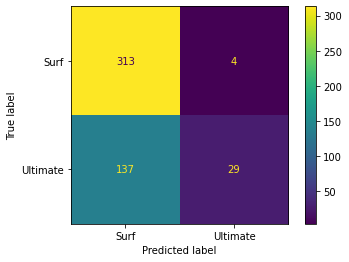

In [20]:
# classification report the lr model of data test
print(classification_report(y_test, y_test_lr_pred, target_names=['Surf', 'Ultimate'])), print()

# display confusion matrix of test data
cm = confusion_matrix(y_test, y_test_lr_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['Surf', 'Ultimate'])
disp.plot()
plt.show() 

- **Precision** in the ultimate package is higher than in the surf package, meaning that the predictions in the ultimate package are more correct than the surf package.

- The **recall** value for the ultimate package is meager, which means that of all the genuinely ultimate data, only a few are predicted correctly.

This model cannot predict the ultimate package well because our data needs to be balanced.

### 4.2. Decision Tree 

In [21]:
# Data train and validation set test
print('Decision Tree Model')
dt_result = defaultdict(list)

for depth in range(1, 11):
    dt_model = DecisionTreeClassifier(max_depth=depth)
    dt_model.fit(X_train, y_train)
    dt_model_train_pred = dt_model.predict(X_train)
    dt_model_valid_pred = dt_model.predict(X_valid)
    dt_result['max_depth'].append(depth)
    dt_result['train_accuracy'].append(accuracy_score(y_train, dt_model_train_pred))
    dt_result['valid_accuracy'].append(accuracy_score(y_valid, dt_model_valid_pred))
    
display(pd.DataFrame(dt_result))

Decision Tree Model


,max_depth,train_accuracy,valid_accuracy
0,1,0.759893,0.744813
1,2,0.790574,0.780083
2,3,0.805247,0.792531
3,4,0.813695,0.792531
4,5,0.825700,0.773859
5,6,0.837261,0.780083
6,7,0.850156,0.767635
7,8,0.861272,0.786307
8,9,0.872388,0.771784
9,10,0.887950,0.780083


We set the **max_depth=3** parameter with a range of **1-11** and get some results of the *accuracy* level, then we use the value **max_depth = 3** because this value has passed the specified threshold value and the *accuracy* level between *data train testing*, *data validation testing*, and *data test testing* produces the most consistent *accuracy* level or whether overfitting or not overfitting


In [22]:
# create decision tree model
dt_model = DecisionTreeClassifier(max_depth=3)
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3)

In [23]:
# accuracy score dt model compare
print('Decision Tree Model')
print('-------------------------')
y_train_dt_pred = dt_model.predict(X_train)
print('Training set accuracy =', accuracy_score(y_train, y_train_dt_pred))
y_valid_dt_pred = dt_model.predict(X_valid)
print('Validation set accuracy =', accuracy_score(y_valid, y_valid_dt_pred))
y_test_dt_pred = dt_model.predict(X_test)
print('Test set accuracy',  accuracy_score(y_test, y_test_dt_pred))

Decision Tree Model
-------------------------
Training set accuracy = 0.8052467763450423
Validation set accuracy = 0.7925311203319502
Test set accuracy 0.7660455486542443


In this model, the *accuracy* level in the *training set* results in a value of **80%**, in the *validation set* results in a matter of **79.2%**, and **76.6%** in the *test set* which makes the model it has passed the *threshold* specified *accuracy* level.

              precision    recall  f1-score   support

        Surf       0.76      0.93      0.84       317
    Ultimate       0.78      0.45      0.57       166

    accuracy                           0.77       483
   macro avg       0.77      0.69      0.70       483
weighted avg       0.77      0.77      0.75       483




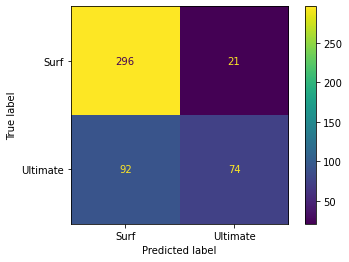

In [24]:
# classification report the dt model of data test
print(classification_report(y_test, y_test_dt_pred, target_names=['Surf', 'Ultimate'])), print()

# display confusion matrix of test data
cm = confusion_matrix(y_test, y_test_dt_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['Surf', 'Ultimate'])
disp.plot()
plt.show() 

- **Precision** for the ultimate package is almost the same as for the surf package, meaning that the correct predictions for the ultimate package and the ultimate surf package are practically equivalent.

- In this model, the **recall** value in the ultimate package is shallow, which means that of all the genuinely ultimate data, only a few are predicted correctly.

This model is also not able to predict the ultimate package well. It might happen because our data needs to be more balanced.

### 4.3. Random Forest

In [25]:
# accuracy score rf model training and validation set test
print('Random Forest Model')
rf_result = defaultdict(list)

for n in range(1,6):
    rf_model = RandomForestClassifier(random_state=42, n_estimators=n)
    rf_model.fit(X_train, y_train) 
    rf_model_train_pred = rf_model.predict(X_train)
    rf_model_valid_pred = rf_model.predict(X_valid)
    rf_result['n_estimators'].append(n)
    rf_result['train_accuracy'].append(accuracy_score(y_train, rf_model_train_pred))
    rf_result['valid_accuracy'].append(accuracy_score(y_valid, rf_model_valid_pred))
    
display(pd.DataFrame(rf_result))

Random Forest Model


,n_estimators,train_accuracy,valid_accuracy
0,1,0.905291,0.724066
1,2,0.916407,0.769710
2,3,0.955091,0.778008
3,4,0.949755,0.769710
4,5,0.966207,0.773859


The results of the **Random Forest Model** show *overfitting* in the *training set* with a value of **95%** against *validation set* resulting in a matter of **77%**, with the `n-estimator` parameter set at value **3**.

In [26]:
# create RandomForestClassifier best model
rf_model = RandomForestClassifier(random_state=42, n_estimators=3) 
rf_model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=3, random_state=42)

In [27]:
# accuracy score rf model compare
print('Random Forest Model')
print('-------------------------')
y_train_rf_pred = rf_model.predict(X_train)
print('Training set accuracy =', accuracy_score(y_train, y_train_rf_pred))
y_valid_rf_pred = rf_model.predict(X_valid)
print('Validation set accuracy =', accuracy_score(y_valid, y_valid_rf_pred))
y_test_rf_pred = rf_model.predict(X_test)
print('Test set accuracy',  accuracy_score(y_test, y_test_rf_pred))

Random Forest Model
-------------------------
Training set accuracy = 0.9550911516229436
Validation set accuracy = 0.7780082987551867
Test set accuracy 0.7536231884057971


The *test set* also did not produce a significant difference by having an *accuracy* level of **75%**. Thus this model does exceed the specified *threshold* value, but *overfitting* occurs, so we cannot use this model.

              precision    recall  f1-score   support

        Surf       0.79      0.86      0.82       317
    Ultimate       0.67      0.55      0.61       166

    accuracy                           0.75       483
   macro avg       0.73      0.71      0.71       483
weighted avg       0.75      0.75      0.75       483




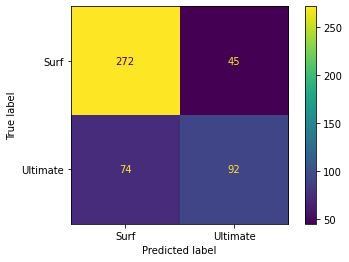

In [28]:
# classification report the rf model of data test
print(classification_report(y_test, y_test_rf_pred, target_names=['Surf', 'Ultimate'])), print()

# display confusion matrix of test data
cm = confusion_matrix(y_test, y_test_rf_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['Surf', 'Ultimate'])
disp.plot()
plt.show() 

- **Precision** in the surf package is higher than the ultimate package, meaning that the predictions in the surf package are more correct than the ultimate package. It is different from the two previous predictions.

- The **recall** value in the ultimate package is lower than the surf package but higher than the two previous models, which means that only a few genuinely ultimate data are predicted correctly.

This model is also unable to predict the ultimate package well. Data imbalance may affect these results.

### 4.4. KNN

In [29]:
# accuracy score knn model training setand validation set test
print('Random Forest Model')
knn_result = defaultdict(list)

for n in [1, 2, 3, 5, 7, 10, 13, 16, 21, 25, 29, 30]:
    knn_model = KNeighborsClassifier(n_neighbors=n)
    knn_model.fit(X_train, y_train) 
    knn_model_train_pred = knn_model.predict(X_train)
    knn_model_valid_pred = knn_model.predict(X_valid)
    knn_result['n_estimators'].append(n)
    knn_result['train_accuracy'].append(accuracy_score(y_train, knn_model_train_pred))
    knn_result['valid_accuracy'].append(accuracy_score(y_valid, knn_model_valid_pred))
    
display(pd.DataFrame(knn_result))

Random Forest Model


,n_estimators,train_accuracy,valid_accuracy
0,1,1.000000,0.690871
1,2,0.839484,0.744813
2,3,0.854602,0.751037
3,5,0.816807,0.753112
4,7,0.807025,0.761411
5,10,0.794131,0.761411
6,13,0.794131,0.763485
7,16,0.779902,0.751037
8,21,0.779458,0.755187
9,25,0.772788,0.755187


In [30]:
# create the best KNeighborsClassifier model
knn_model = KNeighborsClassifier(n_neighbors=30)
knn_model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=30)

The results of the **K-Nearest Neighbors Classifier Model** produce a reasonably good *accuracy* level on *training test* of **76.9%**, and on *validation testing*, make an accuracy rate of **75%**. These numbers meet the threshold criteria of the specified minimum *accuracy* level, and if overfitting does not occur, then we will apply them to the *test set*.

In [31]:
# accuracy score knn model compare
print('K-Nearest Neighbors Model')
print('-------------------------')
y_train_knn_pred = knn_model.predict(X_train)
print('Training set accuracy =', accuracy_score(y_train, y_train_knn_pred))
y_valid_knn_pred = knn_model.predict(X_valid)
print('Validation set accuracy =', accuracy_score(y_valid, y_valid_knn_pred))
y_test_knn_pred = knn_model.predict(X_test)
print('Test set accuracy',  accuracy_score(y_test, y_test_knn_pred))

K-Nearest Neighbors Model
-------------------------
Training set accuracy = 0.7692307692307693
Validation set accuracy = 0.7531120331950207
Test set accuracy 0.7184265010351967


The *test set* presents unfavorable results because the *accuracy* level drops significantly below the *threshold* with the number **71.8%**, which makes this model we cannot use as *machine learning*.

              precision    recall  f1-score   support

        Surf       0.71      0.97      0.82       317
    Ultimate       0.79      0.25      0.38       166

    accuracy                           0.72       483
   macro avg       0.75      0.61      0.60       483
weighted avg       0.74      0.72      0.67       483




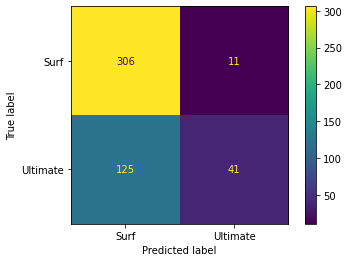

In [32]:
# classification report the knn model of data test
print(classification_report(y_test, y_test_knn_pred, target_names=['Surf', 'Ultimate'])), print()

# display confusion matrix of test data
cm = confusion_matrix(y_test, y_test_knn_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['Surf', 'Ultimate'])
disp.plot()
plt.show() 


- In this model, the results of the **classification report** are almost the same as the results of the **logistic regression** model; **precision** in the ultimate package is higher than the surf package, meaning that the predictions in the ultimate package are more correct than the surf.

- Similar results were obtained for the recall value in the ultimate package, which was very low, implying that only a small percentage of the genuinely ultimate data was correctly predicted.

- This model needs to be able to predict the ultimate package correctly, and unbalanced data can cause this.



## 5. Perform Sanity Check

We will be doing a dummy classifier to make predictions without trying to find patterns in the data. The default model looks at what labels are most frequent in the training dataset and makes predictions based on those labels.

In [33]:
# create the dummy classifier model
dummy_model = DummyClassifier(random_state=42) 
dummy_model.fit(X_train, y_train)

DummyClassifier(random_state=42)

In [34]:
# accuracy score dummy model compare
print('Dummy Classifier Model')
print('-------------------------')
y_train_dummy_pred = dummy_model.predict(X_train)
print('Training set accuracy =', accuracy_score(y_train, y_train_dummy_pred))
y_valid_dummy_pred = dummy_model.predict(X_valid)
print('Validation set accuracy =', accuracy_score(y_valid, y_valid_dummy_pred))
y_test_dummy_pred = dummy_model.predict(X_test)
print('Test set accuracy',  accuracy_score(y_test, y_test_dummy_pred))

Dummy Classifier Model
-------------------------
Training set accuracy = 0.7038683859493108
Validation set accuracy = 0.6825726141078838
Test set accuracy 0.6563146997929606


              precision    recall  f1-score   support

        Surf       0.66      1.00      0.79       317
    Ultimate       0.00      0.00      0.00       166

    accuracy                           0.66       483
   macro avg       0.33      0.50      0.40       483
weighted avg       0.43      0.66      0.52       483




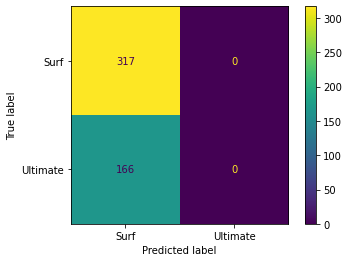

In [35]:
# classification report the dummy model of data test
print(classification_report(y_test, y_test_dummy_pred, target_names=['Surf', 'Ultimate'])), print()

# display confusion matrix of test data
cm = confusion_matrix(y_test, y_test_dummy_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['Surf', 'Ultimate'])
disp.plot()
plt.show() 

Kita mendapatkan hasil untuk accuracy pada baseline model kita sebesar **65%**. Model ini selalu mengembalikan label ke dalam kelas yang paling sering muncul dalam pengamatan.

#Conclusions

**1. Data Preparation**
- We start by loading a dataset consisting of **4** columns and **3214** rows. There are 4 columns described as **float**, i.e., `calls`, `minutes`, `messages`, and `mb_used `.
- We change the `calls` column, which contains the number of calls, and `messages`, which contains the number of sent messages to **int**.

**2. EDA and Data Visualization**
- From the graph of the number of calls made, the average user makes **30-80** calls in one month.
- The average user spends **250-500** minutes on calls in a month.
- On average, users of both packages do not use their text message quota; it might be because they have switched to *instant* messaging or *chatting* applications using internet data.
- Data users use on both plans is around the rate of **10,000-20,000 mb** in one month.

**3. Split the Data**
- We use the `fast_ml.model_development` library to divide the data directly into **3** types in the proportion **70%** *training set*, **15%** *validation set*, and **15%* * for *test sets*.

**4. Models**

We use several models with several settings in the parameters to get the best results:

1. The results of the **Logistic Regression Model** produce an *accuracy* level of **75%** for *training test* and **74%** for *validation test* by setting **newton-cg** on the `solver` parameter. The results of applying the model to the *test set* data were unable to increase the *accuracy* level, and the *accuracy* continued to decrease to **70.8%**, which made this model ineligible to be used as a *machine learning* model.

2. From several *looping* processes that we use in the **Decision Tree Model** we set the **max_dept** parameter with *range* **1-11** and get some *accuracy* level results then we set using value **max_depth = 3**. In this model, the *accuracy* level in the *training set* results in a value of **80%**, in the *validation set* results in a value of **79.2%**, and **76.6%** in the *test set* which makes the model it has passed the *threshold* specified *accuracy* level.

3. The results of the **Random Forest Model** show *overfitting* in the *training set* with a value of **95%** against *validation set* resulting in a value of **77%**, with the `n-estimator` parameter set at value **3**. The *test set* also did not produce a significant difference by producing an *accuracy* level of **75%**. Thus this model does exceed the specified *threshold* value, but *overfitting* occurs, so we cannot use this model.

4. The results of **K-Nearest Neighbors Classifier Model** produce a fairly good *accuracy* level on *training test* of **76.9%**, on *validation testing* produce an accuracy rate of **75%** . The *test set* presents unfavorable results because the *accuracy* level drops significantly below the *threshold* with the number **71.8%**, which makes this model we cannot use as *machine learning*.

All the accuracy results of the above models have surpassed the results of our dummy models.

**Main Conclusion**

We find the best model with the highest *accuracy* value and lowest *margin* in the **Decision Tree Model** with the `max_dept` parameter set to **3**.